# 03: Feature selection, transformations

### import & Data Load

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize_scalar

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression, RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

dh = pd.read_csv('homework_data.csv')


In [2]:
#dh.info()
#dh.head()

### Observe target variable¶

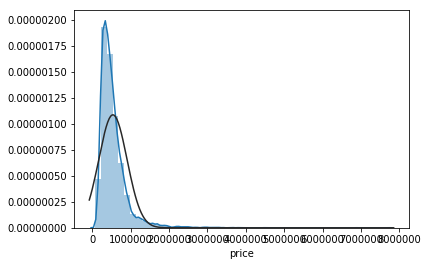

In [3]:
#Analyze the distribution of 'price' and try to transform it into normal distibution.
sns.distplot(dh.price, fit=norm)

In [4]:
# Observe skewness and kurtosis as measures of asymetry and long tails
print(dh.price.skew())
print(dh.price.kurtosis())

# Check log transform
print(np.log1p(dh.price).skew())
print(np.log1p(dh.price).kurtosis())

4.02406914468
34.5855404319
0.428076514957
0.691857220794


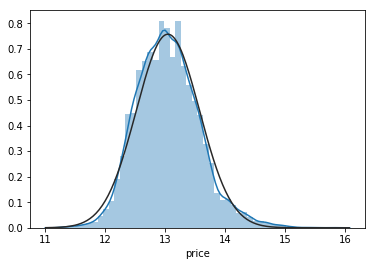

In [5]:
# Try to transform to obtain normal distribution
sns.distplot(np.log1p(dh.price), fit=norm)

In [6]:
# Log transform of price
dh.price = np.log1p(dh.price)



### Simple clean & transform

In [7]:
#Perform proper feature transformations.
#dh.head()

In [8]:
# Fill all NaN with 0
dh.fillna(0, inplace = True)

In [9]:
# This point is not necessary for later get_dummies

# See unique values for object type
#display(dh.select_dtypes(include=['object']).nunique().nlargest(5))
# Convert all object values to categorial format
#dh[dh.select_dtypes(include=['object']).columns] = dh.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

#Anyway no objects

In [10]:
#Just a check of this Regex
dh[dh.filter(regex='^sqft', axis=1).columns].head()
#dh.head()


,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_all,sqft_living2,sqft_lot2,sqft_above2,sqft_basement2,sqft_living152,sqft_lot152,sqft_all2
0,1180,5650,1180,0,1340,5650,15000,34.351128,75.166482,34.351128,0.000000,36.606010,75.166482,122.474487
1,2570,7242,2170,400,1690,7639,21711,50.695167,85.099941,46.583259,20.000000,41.109610,87.401373,147.346530
2,770,10000,770,0,2720,8062,22322,27.748874,100.000000,27.748874,0.000000,52.153619,89.788641,149.405489
3,1960,5000,1050,910,1360,5000,15280,44.271887,70.710678,32.403703,30.166206,36.878178,70.710678,123.612297
4,1680,8080,1680,0,1800,7503,20743,40.987803,89.888820,40.987803,0.000000,42.426407,86.619859,144.024304


In [11]:
#at the end if I add those new columns which corresponds to sqrt and log of columns with sqrt, that increase the error 
#(by 0.03)

# Convert all Area and Square feet to log values
#for column in dh.filter(regex='has', axis=1).columns:
#    dh[column] = (dh[column] > 0).replace({True: 1, False: 0}).astype('uint8')

#for column in dh.filter(regex='^sqft', axis=1).columns:
#    dh['Sqrt' + column] = np.sqrt(dh[column])
#    dh['Log' + column] = np.log1p(dh[column])

# These three features should be categorical 
    #dh['grade']
    #dh['garage_type']
    #dh['waterfront']
    
#Categorical or uint8 doesn't chante anything
# if not pd.api.types.is_categorical_dtype(dh['grade']):
#     dh['grade'] = dh['grade'].astype('uint8'

# if not pd.api.types.is_categorical_dtype(dh['garage_type']):
#     dh['garage_type'] = dh['garage_type'].astype('uint8')

# if not pd.api.types.is_categorical_dtype(dh['waterfront']):
#     dh['waterfront'] = dh['waterfront'].astype('uint8')

In [12]:
# Determine all features with missing data.
#display(dh.isnull().any())

#No null values, no need to delete some features here

In [13]:
#dh.info()

# This is usefull for regression (resonable model) - in the case of classification this is usually not necessary 
#Create a lot of new features (too many), I have to solve this (By dropping Id and Date here)

#ID and Date are useless for the prediction
# Drop Id
dh.drop(['id'], axis = 1, errors = 'ignore', inplace = True)

# Drop Date
dh.drop(['date'], axis = 1, errors = 'ignore', inplace = True)

# Convert categorical variables to indicators and create new data
dh = pd.get_dummies(dh)
# see how many of each type we have
dh.dtypes.value_counts()


#dh.info()
dh.head()


,Unnamed: 0,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,has_sqft_above,sqft_above2,has_sqft_basement,sqft_basement2,has_sqft_living15,sqft_living152,has_sqft_lot15,sqft_lot152,has_sqft_all,sqft_all2
0,0,12.309987,3,1.00,1180,5650,1.0,0,0,3,...,1,34.351128,0,0.000000,1,36.606010,1,75.166482,1,122.474487
1,1,13.195616,3,2.25,2570,7242,2.0,0,0,3,...,1,46.583259,1,20.000000,1,41.109610,1,87.401373,1,147.346530
2,2,12.100718,2,1.00,770,10000,1.0,0,0,3,...,1,27.748874,0,0.000000,1,52.153619,1,89.788641,1,149.405489
3,3,13.311331,4,3.00,1960,5000,1.0,0,0,5,...,1,32.403703,1,30.166206,1,36.878178,1,70.710678,1,123.612297
4,4,13.142168,3,2.00,1680,8080,1.0,0,0,3,...,1,40.987803,0,0.000000,1,42.426407,1,86.619859,1,144.024304


In [14]:
# Remove constant features
display(dh.columns[dh.min() == dh.max()])
dh = dh[dh.columns[dh.min() != dh.max()]]

Index(['has_sqft_living', 'has_sqft_lot', 'has_sqft_above',
       'has_sqft_living15', 'has_sqft_lot15', 'has_sqft_all'],
      dtype='object')

In [15]:
# collect type column names
continuous_columns = dh.select_dtypes(include=['float64']).columns
discrete_columns = dh.select_dtypes(include=['int64']).columns
indicator_columns = dh.select_dtypes(include=['uint8']).columns

print(indicator_columns)


Index([], dtype='object')


### Split train & test data to demonstrate results

In [16]:
#Cross validation
dt, dtest = train_test_split(dh, test_size=0.25, random_state=17)
dt = dt.copy()
dtest = dtest.copy()

In [17]:
print('Train: ', len(dt), '; Test: ', len(dtest))

Train:  16209 ; Test:  5404


## Normalize features

In [18]:
# Check max and min values for indicators  - should be stored in uint8
print(dh.select_dtypes(include=['uint8']).min().min())
print(dh.select_dtypes(include=['uint8']).max().max())


nan
nan


In [19]:
# Standardize scaling
scaler = preprocessing.StandardScaler()

# Prepare column names - ['float64', 'int64', 'uint8']
columns = dt.select_dtypes(include=['float64', 'int64']).columns
columns = columns.drop('price', errors = 'ignore')
print(list(columns))

# Prepare values for transform
scaler.fit(dt[columns])

# Transform
dt[columns] = scaler.transform(dt[columns])
dtest[columns] = scaler.transform(dtest[columns])

['Unnamed: 0', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_all', 'rcprice', 'has_wine_bar', 'garage_type', 'sqft_living2', 'sqft_lot2', 'sqft_above2', 'has_sqft_basement', 'sqft_basement2', 'sqft_living152', 'sqft_lot152', 'sqft_all2']


## Feature selection

### Find irelevant features

In [20]:
#print(dh.head())

# Drop Unamed
dt.drop(['Unnamed: 0'], axis = 1, errors = 'ignore', inplace = True)
dtest.drop(['Unnamed: 0'], axis = 1, errors = 'ignore', inplace = True)

# Drop Id
dt.drop(['id'], axis = 1, errors = 'ignore', inplace = True)
dtest.drop(['id'], axis = 1, errors = 'ignore', inplace = True)

# Drop Date
dt.drop(['date'], axis = 1, errors = 'ignore', inplace = True)
dtest.drop(['date'], axis = 1, errors = 'ignore', inplace = True)

# Find features with low variance
columns_to_remove = dt.columns[dt.var() < 0.02]

#No column has to be removed
print(len(columns_to_remove))

#dh.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace = True)
#dtest.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace = True)

0


In [21]:
# Perform t-test with indicator variables - calculate p-values

ttest_pvals = dh\
    .select_dtypes(include = ['uint8']).columns\
    .to_series()\
    .apply(lambda x: ttest_ind(dh.price[dh[x] == 0], dh.price[dh[x] == 1], equal_var = False).pvalue)


# Remove all largest than 50%
columns_to_remove = list(set(columns_to_remove).union(set(ttest_pvals[ttest_pvals > 0.5].index)))

#No column has to be removed
print(len(columns_to_remove))

#dh.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace = True)
#dtest.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace = True)


0


### Correlation approach

price             1.000000
grade             0.699606
sqft_living       0.693159
sqft_living2      0.691372
sqft_living15     0.616614
sqft_living152    0.614175
sqft_above        0.600310
sqft_above2       0.597657
bathrooms         0.548384
lat               0.448879
Name: price, dtype: float64

price             1.000000
grade             0.653116
sqft_living       0.641697
sqft_living2      0.641697
sqft_living15     0.569205
sqft_living152    0.569205
sqft_above        0.539615
sqft_above2       0.539615
bathrooms         0.494064
lat               0.459188
Name: price, dtype: float64

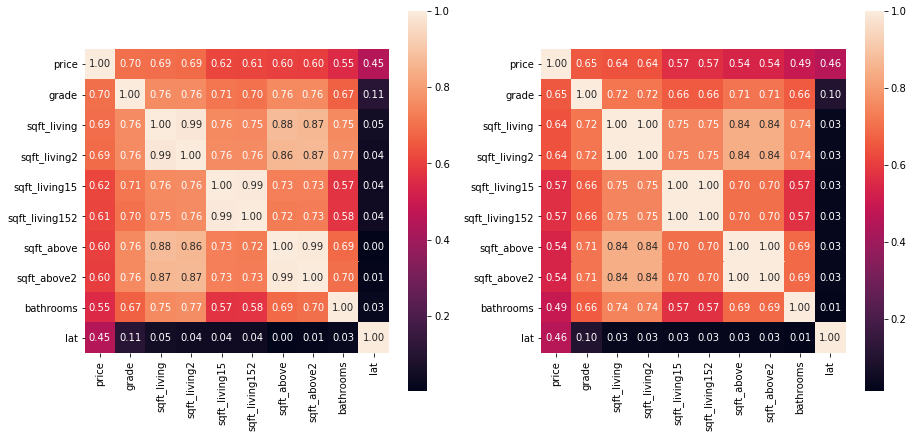

In [22]:
#Correlation

# Correlation matrix Pearson Spearman
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

# Pearson top 10
corrP_cols = corrP.price.abs().nlargest(10).index
display(corrP.price.loc[corrP_cols])
# Spearman top 10
corrS_cols = corrS.price.abs().nlargest(10).index
display(corrS.price.loc[corrS_cols])

#Grade seem to have the higher correlation. It seem normal 
# if the grade is a representation of the overall quality of the house
#Then comes the surface of the house

#Plot those correlations
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.heatmap(corrP.abs().loc[corrP_cols,corrP_cols],ax=axs[0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrP_cols.values, xticklabels=corrP_cols.values)
sns.heatmap(corrS.abs().loc[corrS_cols,corrS_cols],ax=axs[1], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrS_cols.values, xticklabels=corrS_cols.values)

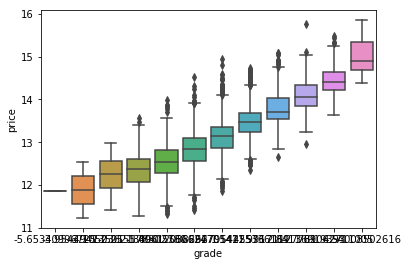

In [23]:
sns.boxplot(x='grade', y='price', data=dt)

## Subset selection

In [24]:
# Use scikit learn to select best features
# prepare data
X = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['price'], axis = 1, errors = 'ignore')
y = dt.price


# calculate F values for correlation coefficient (calculated from rho using an increasing function)
# calculate p-values of the correspondong F-test (inversely proportional to rho)
Fscores, pvals = f_regression(X,y)
print(max(pvals))

0.897744459267


In [25]:
display(pd.Series(pvals, index=X.columns).nsmallest(5))
display(corrP.price.abs().nlargest(5))

bedrooms       0.0
bathrooms      0.0
sqft_living    0.0
floors         0.0
view           0.0
dtype: float64

price            1.000000
grade            0.699606
sqft_living      0.693159
sqft_living2     0.691372
sqft_living15    0.616614
Name: price, dtype: float64

In [26]:
# Stupid selection of n performing highest correlations
n = 30
columns_to_leave = corrP.price.abs().nlargest(n).index

In [27]:
# Select by linear regression
X = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['price'], axis = 1, errors = 'ignore')
y = dt.price

used_columns = X.columns

def scorer(Y, yp):
    return np.sqrt(mean_squared_error(Y, yp))

clfM = LinearRegression()

selector = RFECV(clfM, step=1, cv=5, scoring=make_scorer(scorer))
selector = selector.fit(X, y)

# transform result to dataframe
result = pd.DataFrame({'Chosen': selector.support_, 'Ranking': selector.ranking_}, index=list(used_columns))

# columns to leave (commented because only one column is chosen, I don't know why)
#columns_to_leave = result[result.Chosen == True].index

# show results
display(result[result.Chosen == False].head(5))
display(result.Chosen)

,Chosen,Ranking
bedrooms,False,20
bathrooms,False,15
sqft_living,False,22
sqft_lot,False,24
floors,False,21


bedrooms             False
bathrooms            False
sqft_living          False
sqft_lot             False
floors               False
waterfront           False
view                 False
condition            False
grade                False
sqft_above           False
sqft_basement        False
yr_built             False
yr_renovated         False
zipcode              False
lat                  False
long                 False
sqft_living15        False
sqft_lot15           False
sqft_all             False
rcprice              False
has_wine_bar         False
garage_type          False
sqft_living2         False
sqft_lot2            False
sqft_above2          False
has_sqft_basement    False
sqft_basement2       False
sqft_living152       False
sqft_lot152          False
sqft_all2             True
Name: Chosen, dtype: bool

## Estimation - Linear Regression

Root mean squared logarithmic error: 0.246249461073


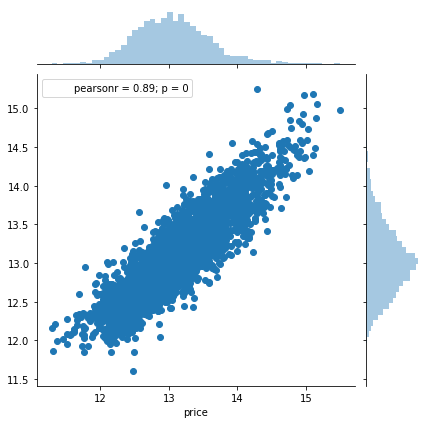

In [28]:
# Data prepare
X = dt[columns_to_leave].drop(['price'], axis = 1, errors = 'ignore')
y = dt.price
Xtest = dtest[columns_to_leave].drop(['price'], axis = 1, errors = 'ignore')
ytest = dtest.price

# Linear Regression
clf1 = LinearRegression()
clf1.fit(X, y) 

# Print RMSLE
print('Root mean squared logarithmic error:', np.sqrt(mean_squared_error(clf1.predict(Xtest), ytest)))

# Joint Plot
sns.jointplot(ytest, clf1.predict(Xtest))

In [29]:
#I'm not able to decrease the error below 0.246
# - With feature selection from correlation, this is the best score that I get
# - With feature selection with RFECV, only one feature is selected, I don't know why

# First Root mean squared logarithmic error: 0.345332452887, not really good
#THen 0.52
#Then 0.41 .. Because only one feature is selected
#Then 0.52, I'm stuck here
# With "stupid" selection : 0.28 (with 10 features)
# With "stupid" selection : 0.267 (with 20 features)
# With "stupid" selection : 0.246 (with 30 features)
# With "stupid" selection : 0.27 (with 30 features) with Log and Sqrt of sqft added
